In [35]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [36]:
def imread_gs(path: str) -> np.ndarray:
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def show(img: np.ndarray) -> None:
    plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap='gray')

In [63]:
f0 = imread_gs('data/20240306/E1_2024-03-06-170901-0000.tif')

1. find max sum axis=1
2. cut off signal on laser side (flip if necessary)
3. find new max sum axis=1

In [64]:
f0_max1 = np.where(f0.sum(axis=1) == f0.sum(axis=1).max())[0][0]
WIDTH = 15

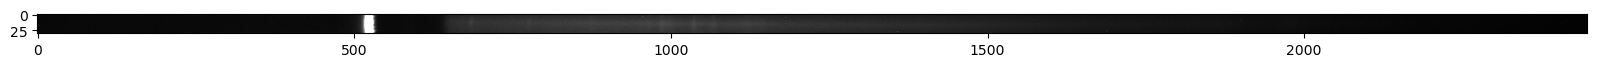

In [65]:
show(f0[ f0_max1-WIDTH:f0_max1+WIDTH, ::-1])

In [66]:
center_line = f0[f0_max1, :]
laser_loc = np.where(center_line == max(center_line))[0][0]
laser_left = laser_loc < len(center_line)/2

if laser_left:
    f0 = np.flip(f0, axis=1)
    center_line = f0[f0_max1, ::-1]
    laser_loc = np.where(center_line == max(center_line))[0][0]

center_gradient = np.gradient(gaussian_filter(center_line, 5))
laser_onset_loc = np.where(center_gradient[:laser_loc] == 0)[0][-1]

gradient_condition = center_gradient[:laser_onset_loc] > -1
brightness_condition = center_line[:laser_onset_loc] > 50
signal_loc = np.where(gradient_condition & brightness_condition)[0][-1]

In [67]:
f0 = f0[:, :signal_loc+1]
f0_max = np.where(f0.sum(axis=1) == f0.sum(axis=1).max())[0][0]
f0_max

640

In [68]:
len(f0_s)

1792

In [69]:
signal_loc

1791

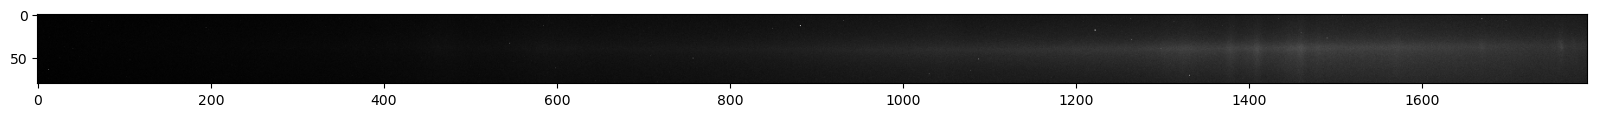

In [70]:
show(f0[600:680, :])

In [71]:
f0_c = np.flip(f0[f0_max-WIDTH:f0_max+WIDTH, :], axis=1)  # cropped

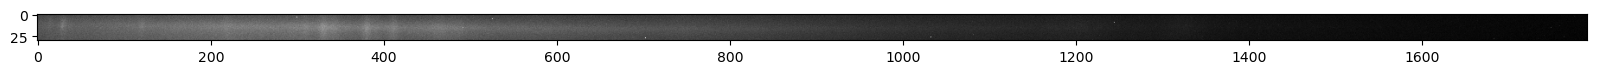

In [72]:
show(f0_c)

In [73]:
f0_s = f0_c.sum(axis=0, dtype=np.int64)  # spectrum

# minima, maxima

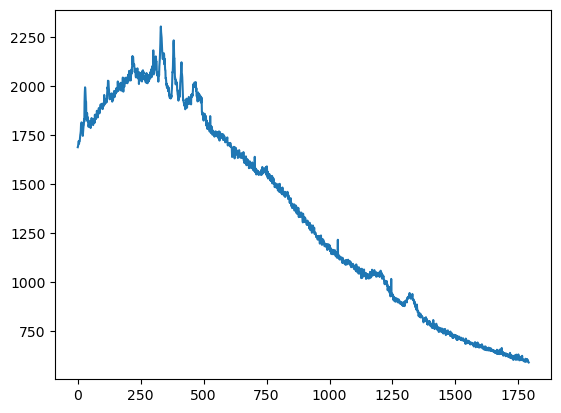

In [56]:
plt.plot(f0_s)

[  15   30  121  219  259  300  310  331  381  412  465  627  746 1032
 1177 1318]
16


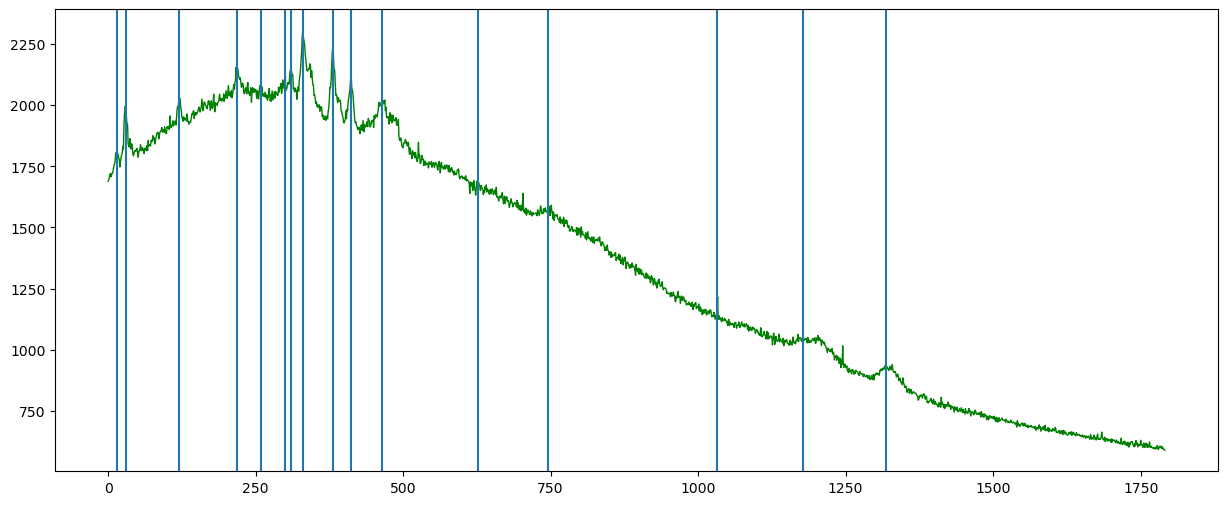

In [57]:
f0_smoothed = gaussian_filter(f0_s, 2)
f0_peaks = find_peaks(f0_smoothed, prominence=10)[0]
print(f0_peaks)
print(len(f0_peaks))

plt.figure(figsize=(15, 6))
# plt.plot(f0_smoothed, 'r--', lw=1)
plt.plot(f0_s, 'g', lw=1)
for x in f0_peaks:
    plt.axvline(x)

[  19   43   50  136  252  268  318  366  399  425  718 1153 1292]


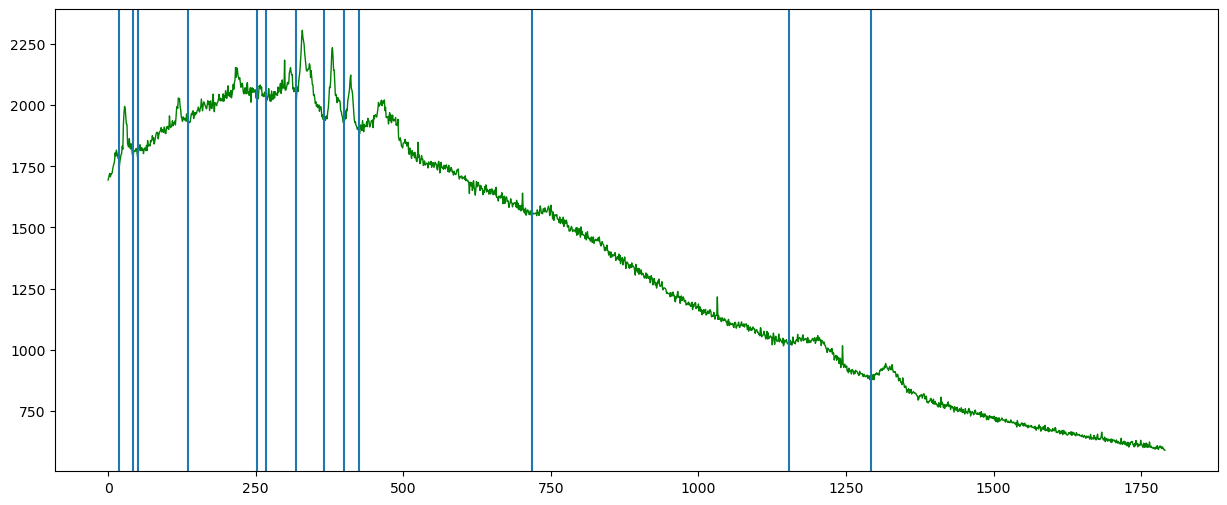

In [14]:
f0_smoothed = gaussian_filter(f0_s, 2)
f0_minima = find_peaks(-f0_smoothed, prominence=15)[0]
print(f0_minima)

plt.figure(figsize=(15, 6))
# plt.plot(f0_smoothed, 'r--', lw=1)
plt.plot(f0_s, 'g', lw=1)
for x in f0_minima:
    plt.axvline(x)

In [15]:
def gnorm(spec):
    return (spec - np.mean(spec))/np.std(spec)

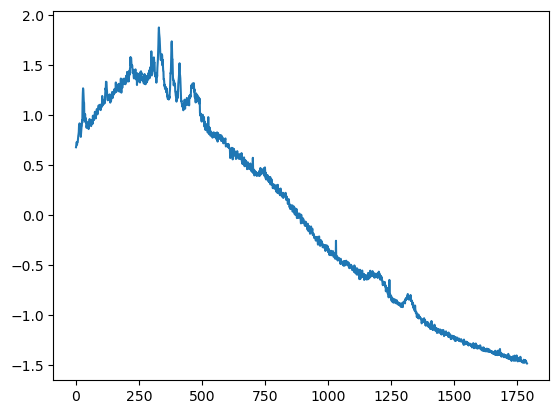

In [16]:
plt.plot(gnorm(f0_s))

# reference spectrum of corundum

In [17]:
def readline(line: str) -> tuple[float, float]:
    x, y = line.split('\t')
    return (float(x), float(y))

In [18]:
with open('data/sapphire_ref_cm++.txt') as f:
    sap_ref = [ readline(l) for l in f.readlines()[1:] ]

In [19]:
wvns, vals = np.array(sap_ref).transpose()
wvls = 2*np.pi/wvns

In [20]:
wvns = wvns[10:]
vals = vals[10:]
wvls = wvls[10:]

[379.02891, 416.36703, 644.43098, 1994.56975]


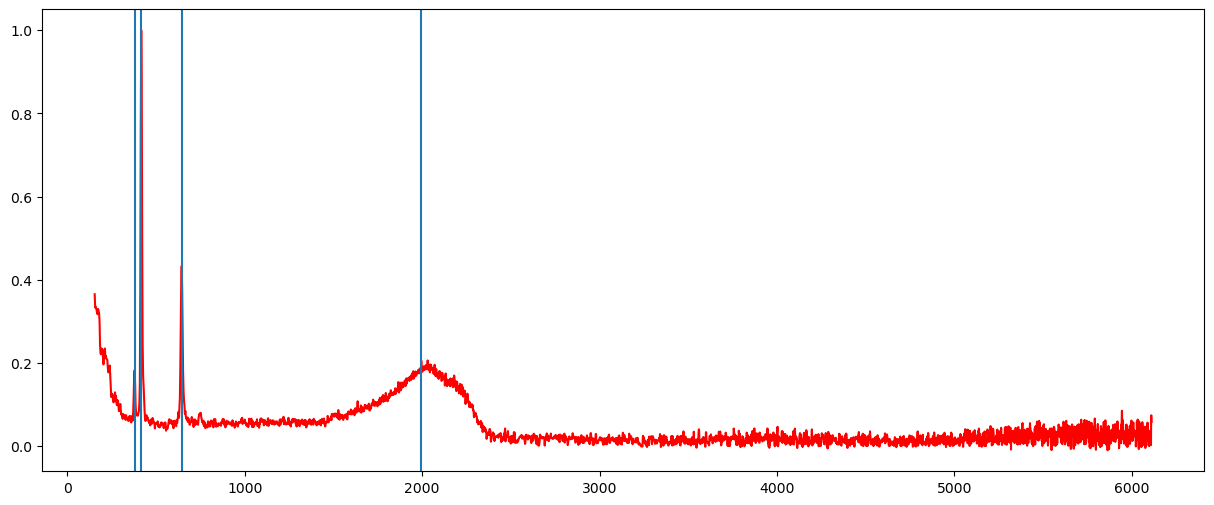

In [21]:
plt.figure(figsize=(15, 6))
plt.plot(wvns, vals, 'r')

ref_peak_n = find_peaks(vals, prominence=.1)[0]
ref_peaks = [ wvns[p] for p in ref_peak_n ]
print(ref_peaks)
for p in ref_peaks:
    plt.axvline(p)

# calibration

In [22]:
BADNESS_THRESHOLD = 5e-4

In [23]:
f0_fit = np.poly1d(np.polyfit(f0_peaks[:3], ref_peaks[:3], 2))
print(f0_fit)
f0_lin = np.poly1d(np.polyfit(f0_peaks[:3], ref_peaks[:3], 1))
print(f0_lin)
if np.abs(f0_fit.coef[0]/f0_fit.coef[1]) > BADNESS_THRESHOLD:  # the first reference peak was likely not detected
    f0_fit = np.poly1d(np.polyfit(f0_peaks[:2], ref_peaks[1:3], 1))

f0_wvn = f0_fit(np.arange(0, len(f0_s)))
f0_fit

           2
0.0001603 x + 2.482 x + 344.2
 
2.505 x + 343.9


poly1d([1.60275969e-04, 2.48231613e+00, 3.44245070e+02])

[379.0289099999997, 416.36702999999983, 644.4309799999996]


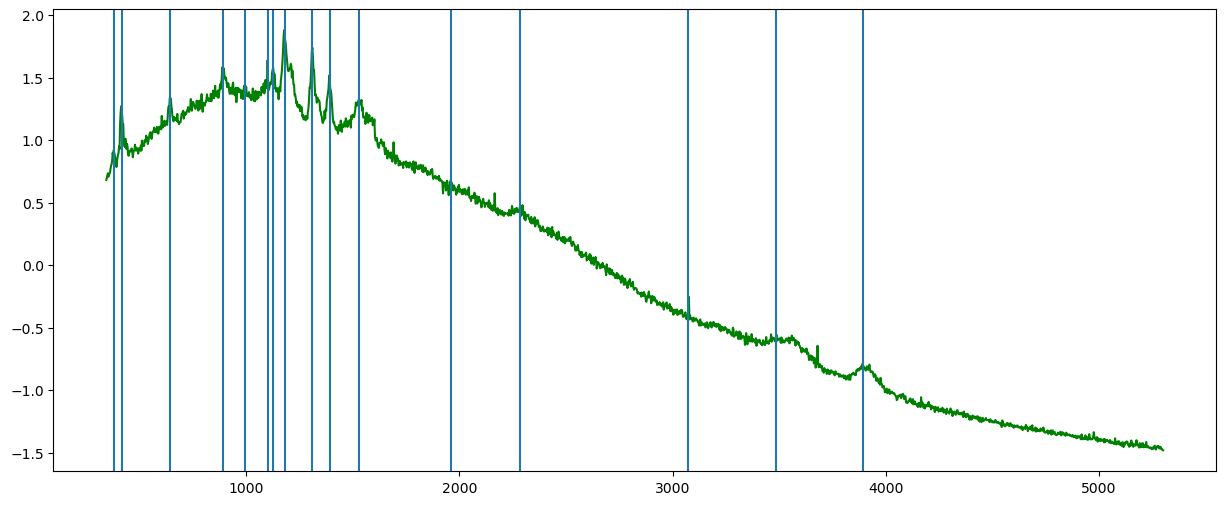

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(f0_wvn, gnorm(f0_s), 'g')
for x in f0_peaks:
    plt.axvline(f0_wvn[x])

print([f0_wvn[x] for x in f0_peaks[:3]])

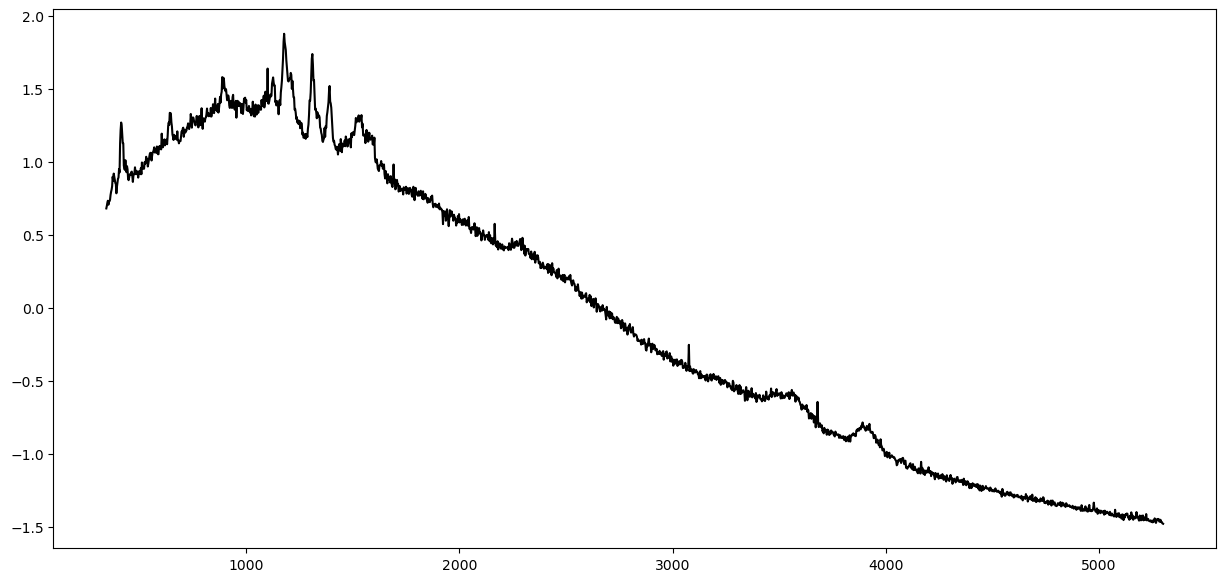

In [25]:
plt.figure(figsize=(15, 7))
plt.plot(f0_wvn, gnorm(f0_s), c='black')

# noise median method

In [26]:
maxima = np.where((f0_s[1:-1] > f0_s[2:]) & (f0_s[1:-1] > f0_s[:-2]))[0] + 1
minima = np.where((f0_s[1:-1] < f0_s[2:]) & (f0_s[1:-1] < f0_s[:-2]))[0] + 1

extrema = np.concatenate((maxima, minima))

In [27]:
MEDIAN_RADIUS = 17
CONV_SIGMA = 15
PERCENTILE = 80

noise_median = np.empty_like(f0_s)
for i in np.arange(f0_s.shape[0]):
    m = max(i - MEDIAN_RADIUS, 0)
    M = min(i + MEDIAN_RADIUS, f0_s.shape[0]-1)

    extreme_values = f0_s[extrema[(extrema >= m) & (extrema <= M)]]
    less_extreme_values = extreme_values[extreme_values < np.percentile(extreme_values, PERCENTILE)]

    noise_median[i] = np.median(less_extreme_values)

bckg = gaussian_filter(noise_median, CONV_SIGMA)

In [28]:
f0_s.shape

(1791,)

In [32]:
def remove_bckg(data, halfwidth, sigma, pct):
    maxima = np.where((data[1:-1] > data[2:]) & (data[1:-1] > data[:-2]))[0] + 1
    minima = np.where((data[1:-1] < data[2:]) & (data[1:-1] < data[:-2]))[0] + 1
    extrema = np.concatenate((maxima, minima))

    noise_median = np.empty_like(data)
    for i in np.arange(data.shape[0]):
        m = max(i - halfwidth, 0)
        M = min(i + halfwidth, data.shape[0]-1)
    
        extreme_values = data[extrema[(extrema >= m) & (extrema <= M)]]
        if pct < 100:
            less_extreme_values = extreme_values[extreme_values < np.percentile(extreme_values, pct)]
            noise_median[i] = np.median(less_extreme_values)
        else:
            noise_median[i] = np.median(extreme_values)
    
    return data - gaussian_filter(noise_median, sigma)

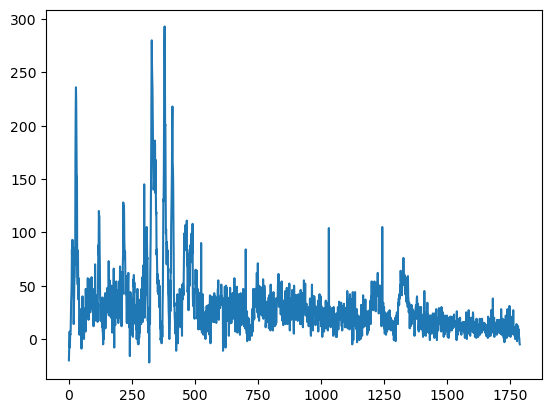

In [34]:
remove_bckg(f0_s, 20, 10, 20)

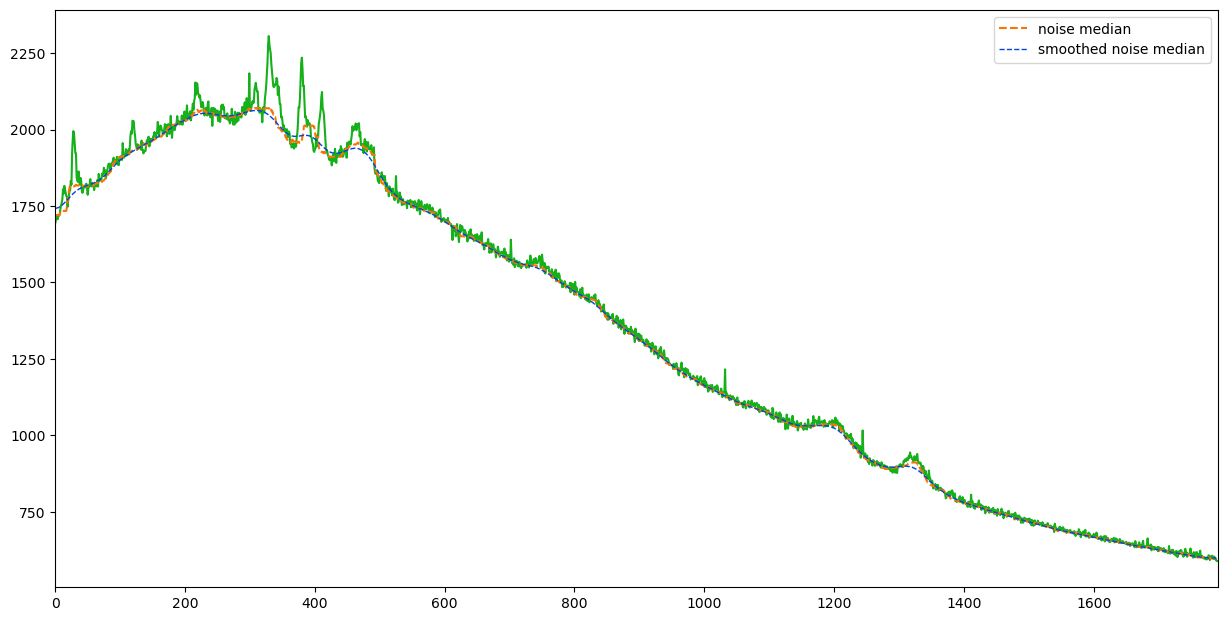

In [168]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_s, c='xkcd:green')
plt.plot(noise_median, c='xkcd:orange', ls='--', lw=1.5, label='noise median')
plt.plot(bckg, c='xkcd:blue', ls='--', lw=1, label='smoothed noise median')
plt.xlim(0, len(f0_s))
plt.legend()
# plt.scatter(np.arange(f0_s.shape[0]), f0_s, c='xkcd:green')
# for i in extrema:
#     plt.axvline(i, ls='--', c='xkcd:orange', lw=1)


# plt.xlim(50, 150)

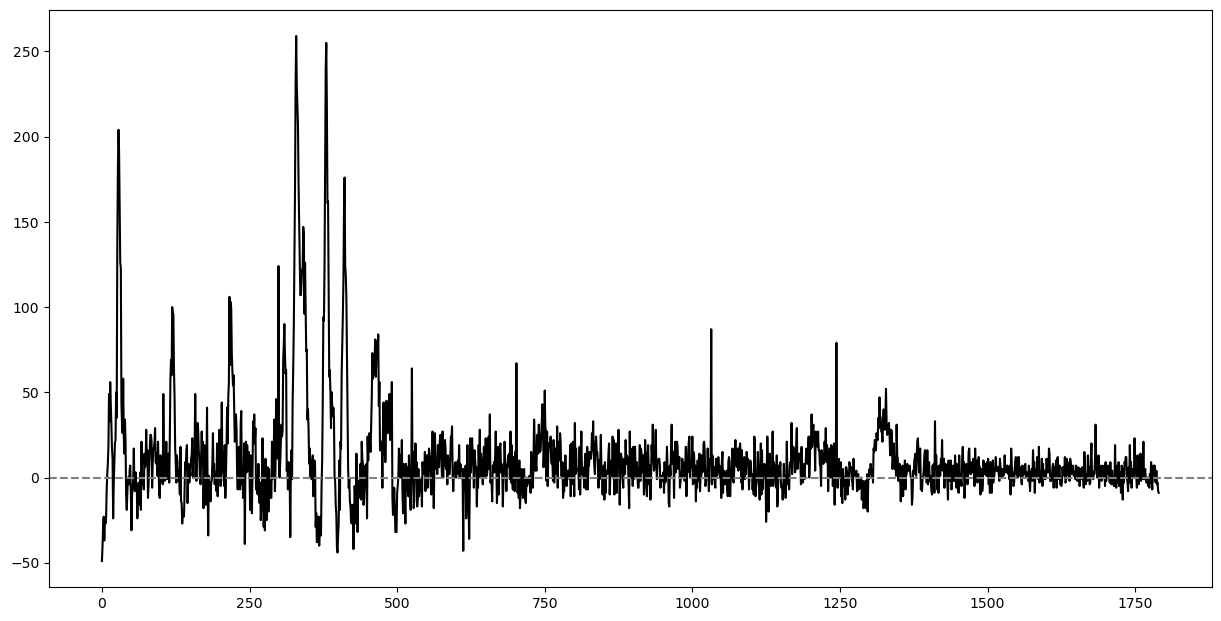

In [135]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_s - bckg, c='xkcd:black')
plt.axhline(0, ls='--', c='gray')

In [175]:
%timeit remove_bckg(f0_s, 20, 10, 80)

231 ms ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


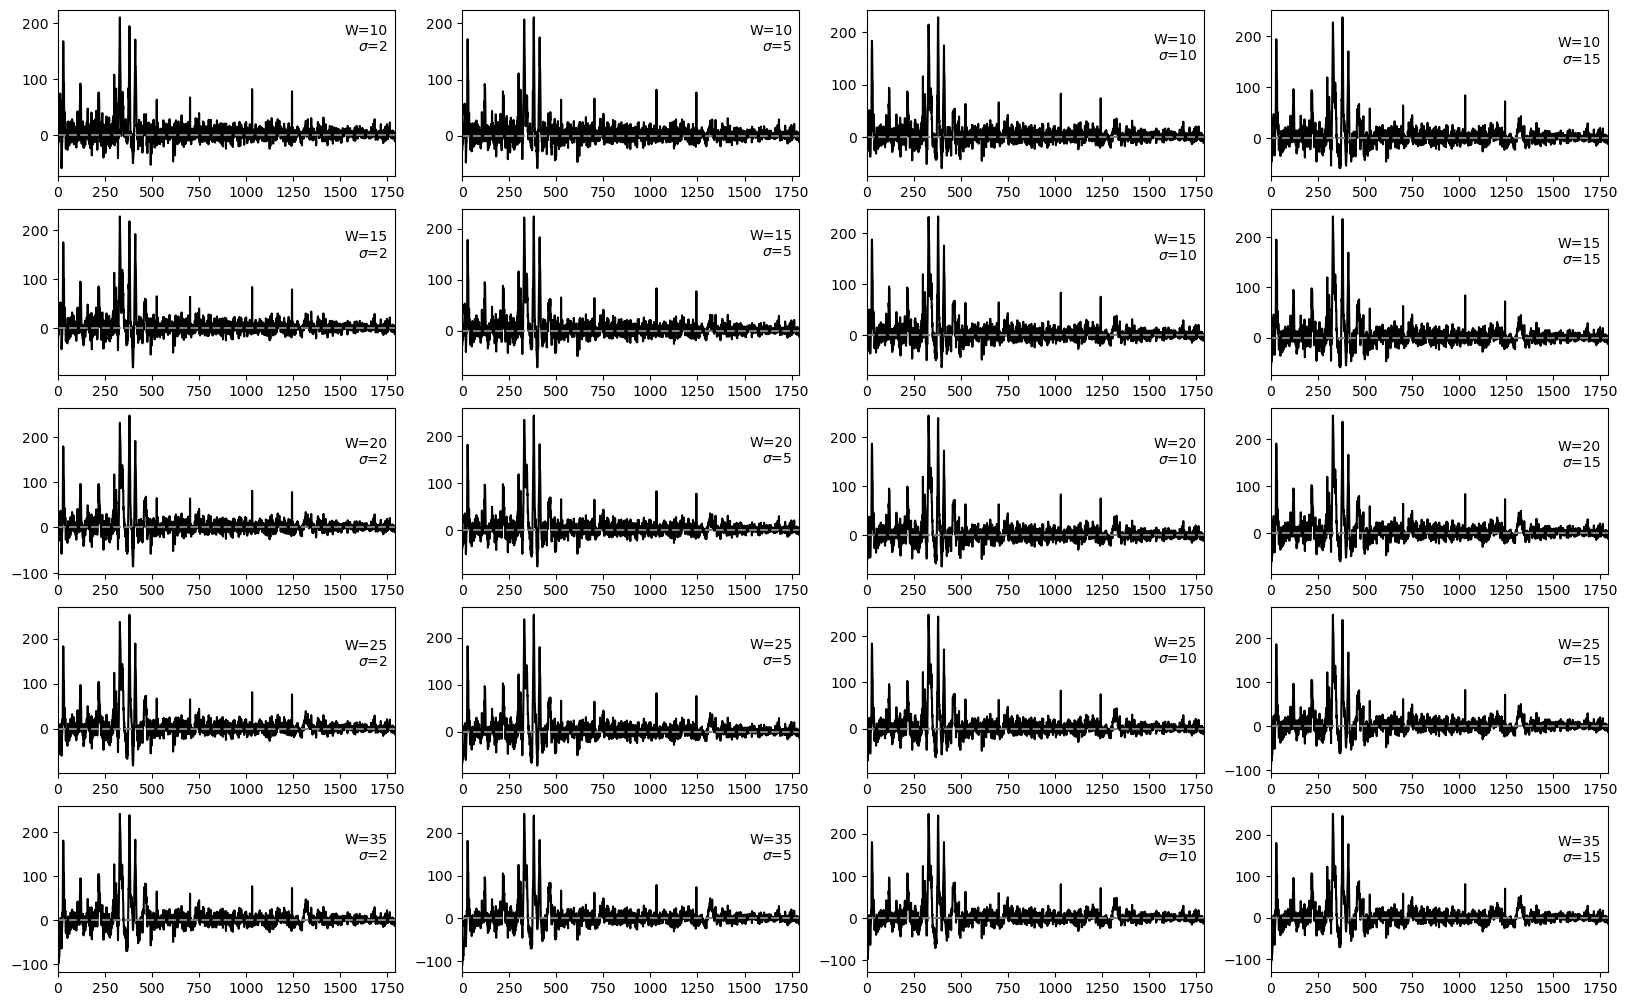

In [164]:
n_sigmas, n_widths = 4, 5
widths = [10, 15, 20, 25, 35]
sigmas = [2, 5, 10, 15]
maxlim = f0_s.shape[0]

fig, ax = plt.subplots(n_widths, n_sigmas, figsize=(5*n_sigmas, 2.5*n_widths))

for i in range(n_widths):
    for j in range(n_sigmas):
        width = widths[i]
        sigma = sigmas[j]
        
        ax[i][j].text(0.98*maxlim, 200, f'W={width}\n$\\sigma$={sigma}',
            horizontalalignment='right',
            verticalalignment='top')
        ax[i][j].plot(remove_bckg(f0_s, width, sigma, 100), c='black')
        ax[i][j].axhline(0, c='gray', ls='--')
        ax[i][j].set_xlim(0, maxlim)

plt.savefig('parametra_p100.png', dpi=1500)

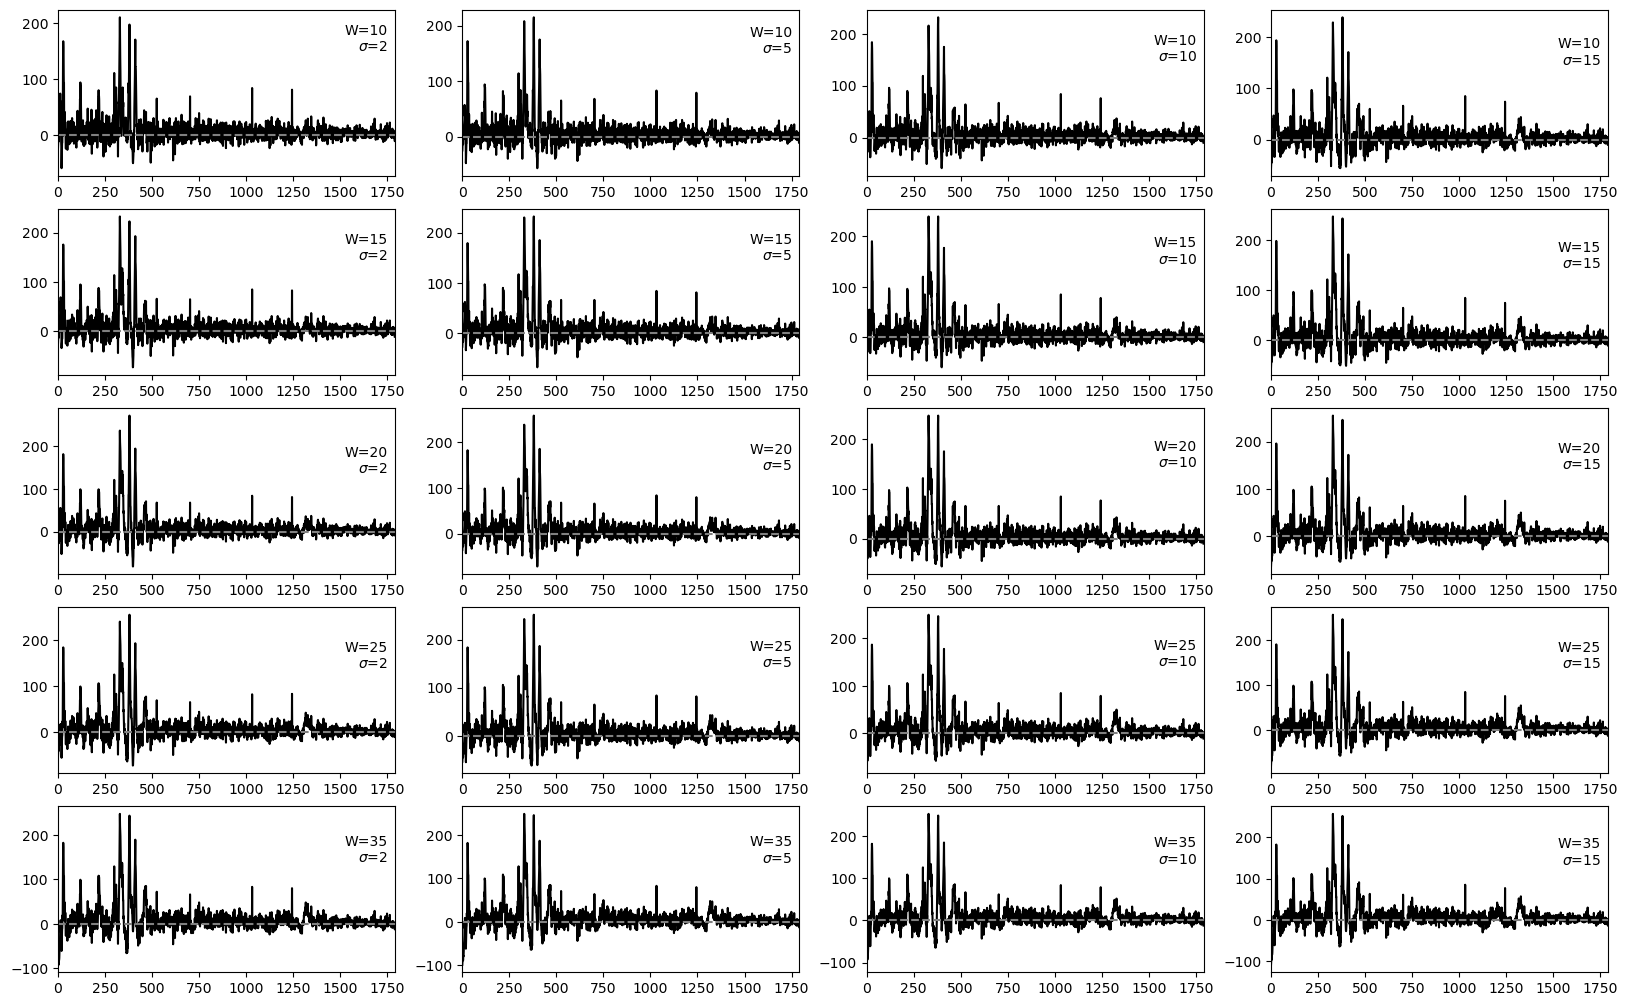

In [165]:
n_sigmas, n_widths = 4, 5
widths = [10, 15, 20, 25, 35]
sigmas = [2, 5, 10, 15]
maxlim = f0_s.shape[0]

fig, ax = plt.subplots(n_widths, n_sigmas, figsize=(5*n_sigmas, 2.5*n_widths))

for i in range(n_widths):
    for j in range(n_sigmas):
        width = widths[i]
        sigma = sigmas[j]
        
        ax[i][j].text(0.98*maxlim, 200, f'W={width}\n$\\sigma$={sigma}',
            horizontalalignment='right',
            verticalalignment='top')
        ax[i][j].plot(remove_bckg(f0_s, width, sigma, 90), c='black')
        ax[i][j].axhline(0, c='gray', ls='--')
        ax[i][j].set_xlim(0, maxlim)

plt.savefig('parametra_p90.png', dpi=1500)

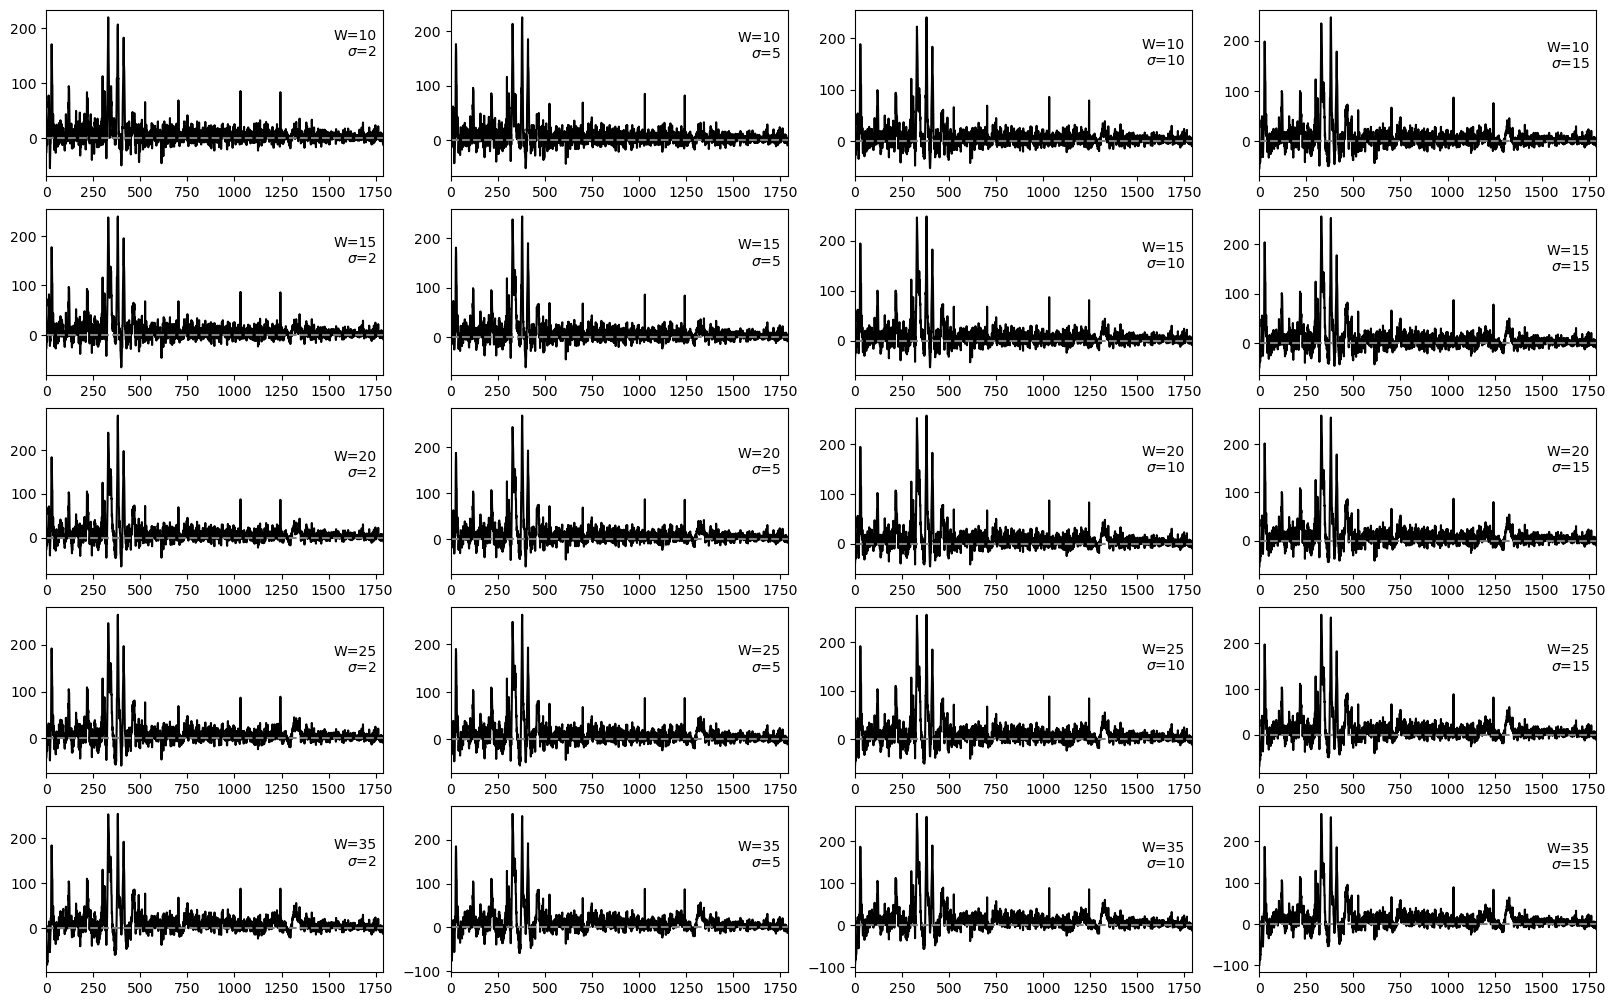

In [166]:
n_sigmas, n_widths = 4, 5
widths = [10, 15, 20, 25, 35]
sigmas = [2, 5, 10, 15]
maxlim = f0_s.shape[0]

fig, ax = plt.subplots(n_widths, n_sigmas, figsize=(5*n_sigmas, 2.5*n_widths))

for i in range(n_widths):
    for j in range(n_sigmas):
        width = widths[i]
        sigma = sigmas[j]
        
        ax[i][j].text(0.98*maxlim, 200, f'W={width}\n$\\sigma$={sigma}',
            horizontalalignment='right',
            verticalalignment='top')
        ax[i][j].plot(remove_bckg(f0_s, width, sigma, 80), c='black')
        ax[i][j].axhline(0, c='gray', ls='--')
        ax[i][j].set_xlim(0, maxlim)

plt.savefig('parametra_p80.png', dpi=1500)

# fitanje minimuma (weighted)

In [251]:
m1 = (f0_wvn > 1800) & (f0_wvn < 2000)
g1 = 20
m2 = f0_wvn > 4200
g2 = 20
m3 = (f0_wvn > 2900) & (f0_wvn < 3100)
g3 = 20

f0_min_wvn = [ *[ f0_wvn[x] for x in f0_minima ], *f0_wvn[m1][::g1], *f0_wvn[m2][::g2], *f0_wvn[m3][::g3] ]
f0_min_h = [ *[ gnorm(f0_s)[x] for x in f0_minima ], *gnorm(f0_s)[m1][::g1], *gnorm(f0_s)[m2][::g2], *gnorm(f0_s)[m3][::g3] ]
weights = [4]*len(f0_minima) + [1]*(len(f0_min_wvn) - len(f0_minima))

f0_fit_1w = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 4, w=weights))
f0_fit_2w = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 8, w=weights))
t = time()
f0_fit_3w = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 12, w=weights))
print(time() - t)

f0_fit_w = [ f0_fit_1w, f0_fit_2w, f0_fit_3w ]

0.00043773651123046875


In [252]:
wl = [ f'weighted x^{x}' for x in (3, 7, 11) ]
ul = [ f'unweighted x^{x}' for x in (3, 7, 11) ]
cl = [ 'gray', 'green', 'red' ]

(344.2450700435409, 5301.13118196319)

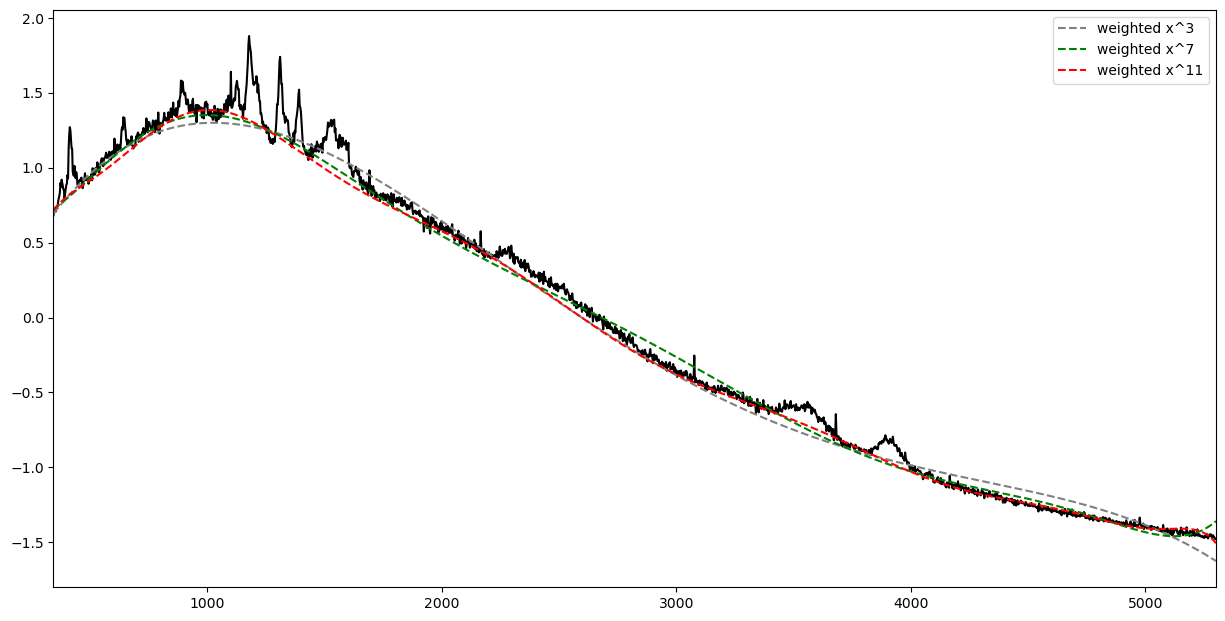

In [253]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
for i in range(3):
    plt.plot(f0_wvn, f0_fit_w[i](f0_wvn), c=cl[i],  ls='--', label=wl[i])
plt.legend()
plt.xlim(min(f0_wvn), max(f0_wvn))

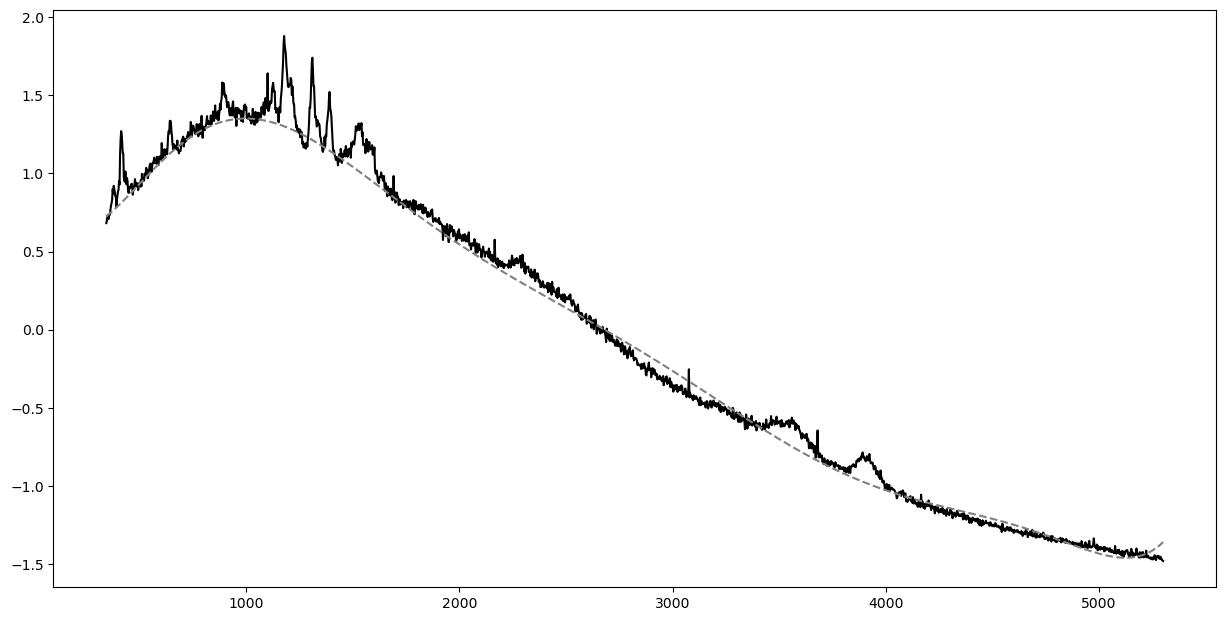

In [254]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
plt.plot(f0_wvn, f0_fit_w[1](f0_wvn), c='gray', ls='--')

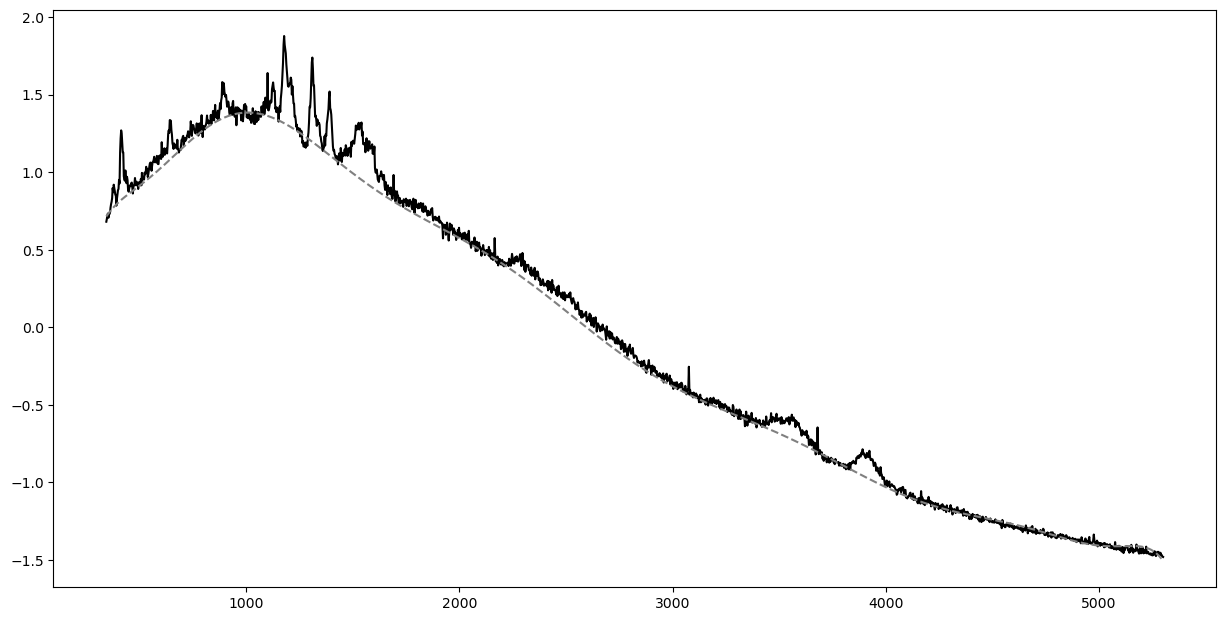

In [255]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
plt.plot(f0_wvn, f0_fit_w[2](f0_wvn), c='gray', ls='--')

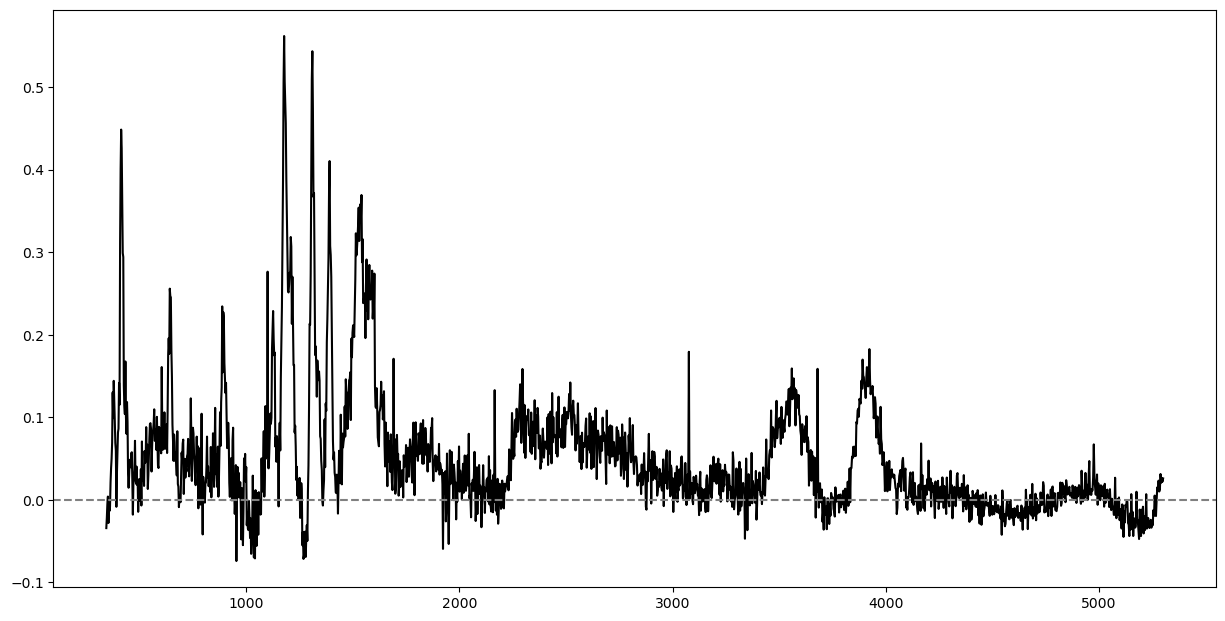

In [256]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s) - f0_fit_w[2](f0_wvn), c='black')
plt.axhline(c='gray', ls='--')

# fitanje minimuma (unweighted)

In [257]:
from time import time

In [258]:
f0_fit_1u = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 4))
f0_fit_2u = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 8))
t = time()
f0_fit_3u = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 12))
print(time() - t)

f0_fit_u = [ f0_fit_1u, f0_fit_2u, f0_fit_3u ]

0.0004756450653076172


(344.2450700435409, 5301.13118196319)

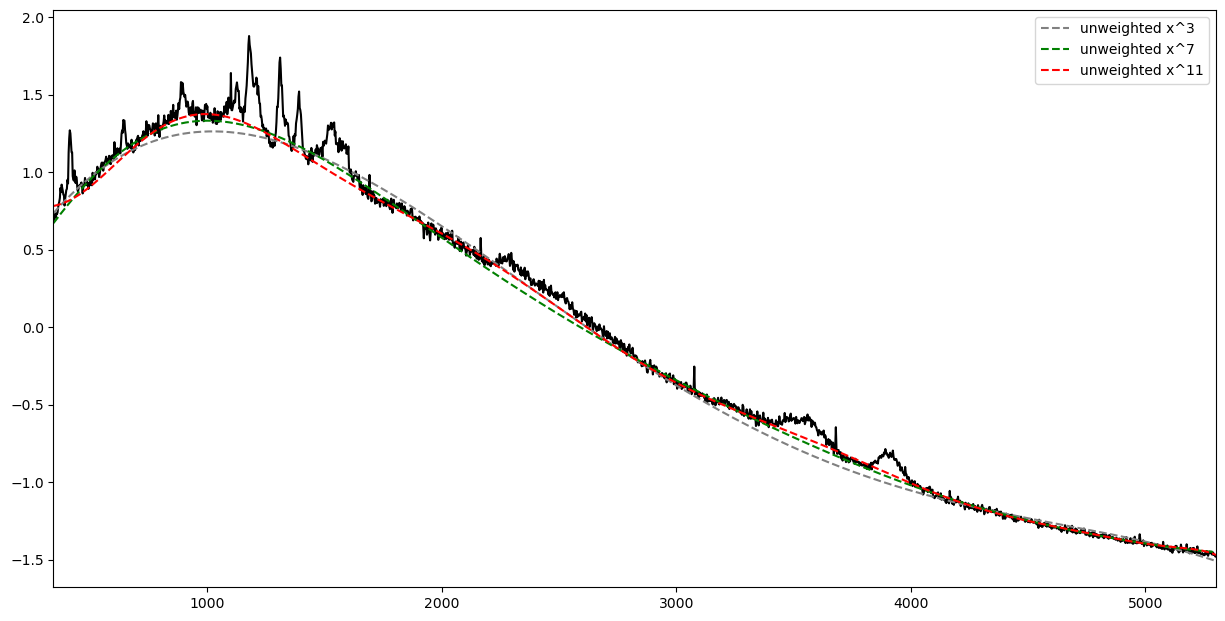

In [259]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
for i in range(3):
    plt.plot(f0_wvn, f0_fit_u[i](f0_wvn), c=cl[i],  ls='--', label=ul[i])
plt.legend()
plt.xlim(min(f0_wvn), max(f0_wvn))

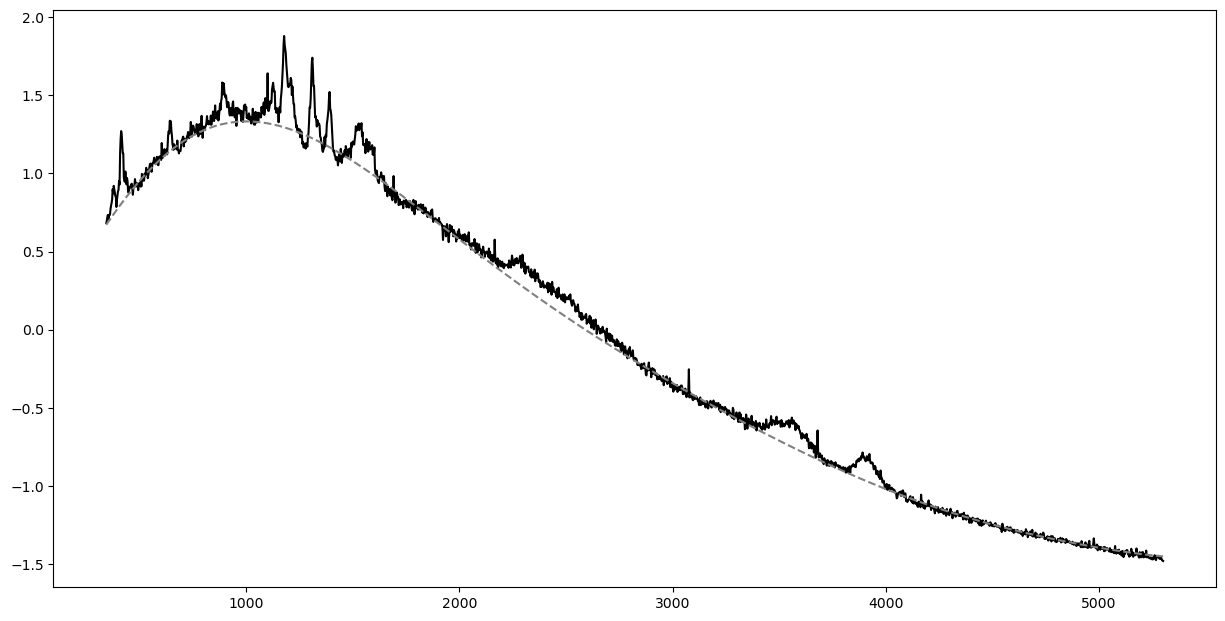

In [260]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
plt.plot(f0_wvn, f0_fit_2u(f0_wvn), c='gray', ls='--')

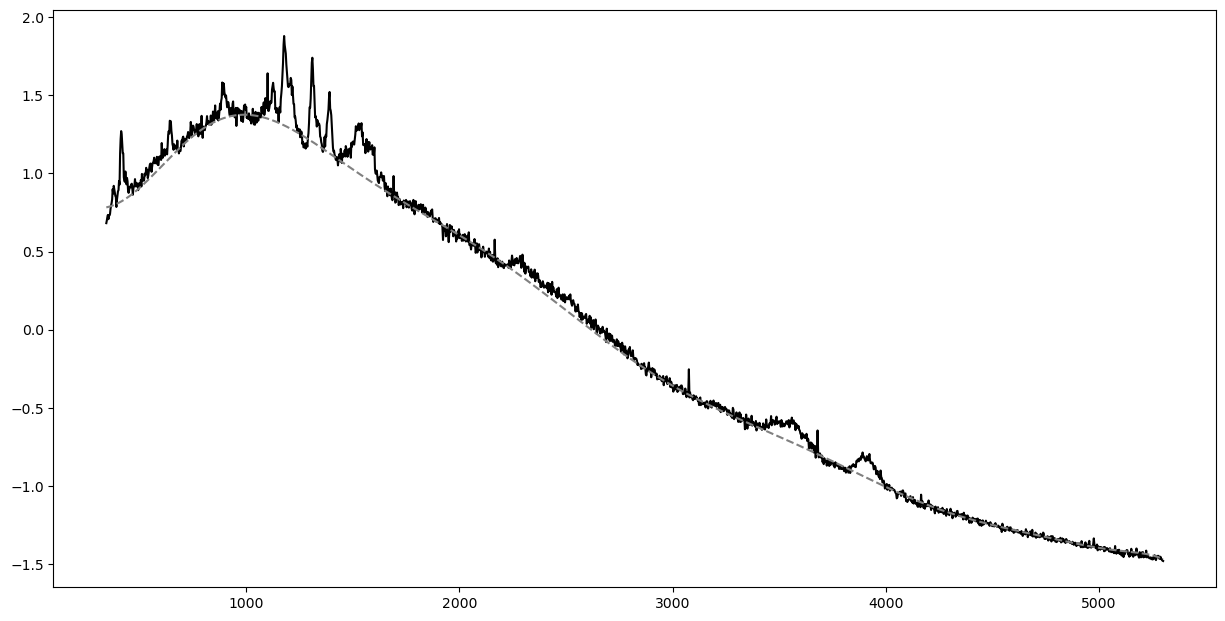

In [261]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
plt.plot(f0_wvn, f0_fit_3u(f0_wvn), c='gray', ls='--')

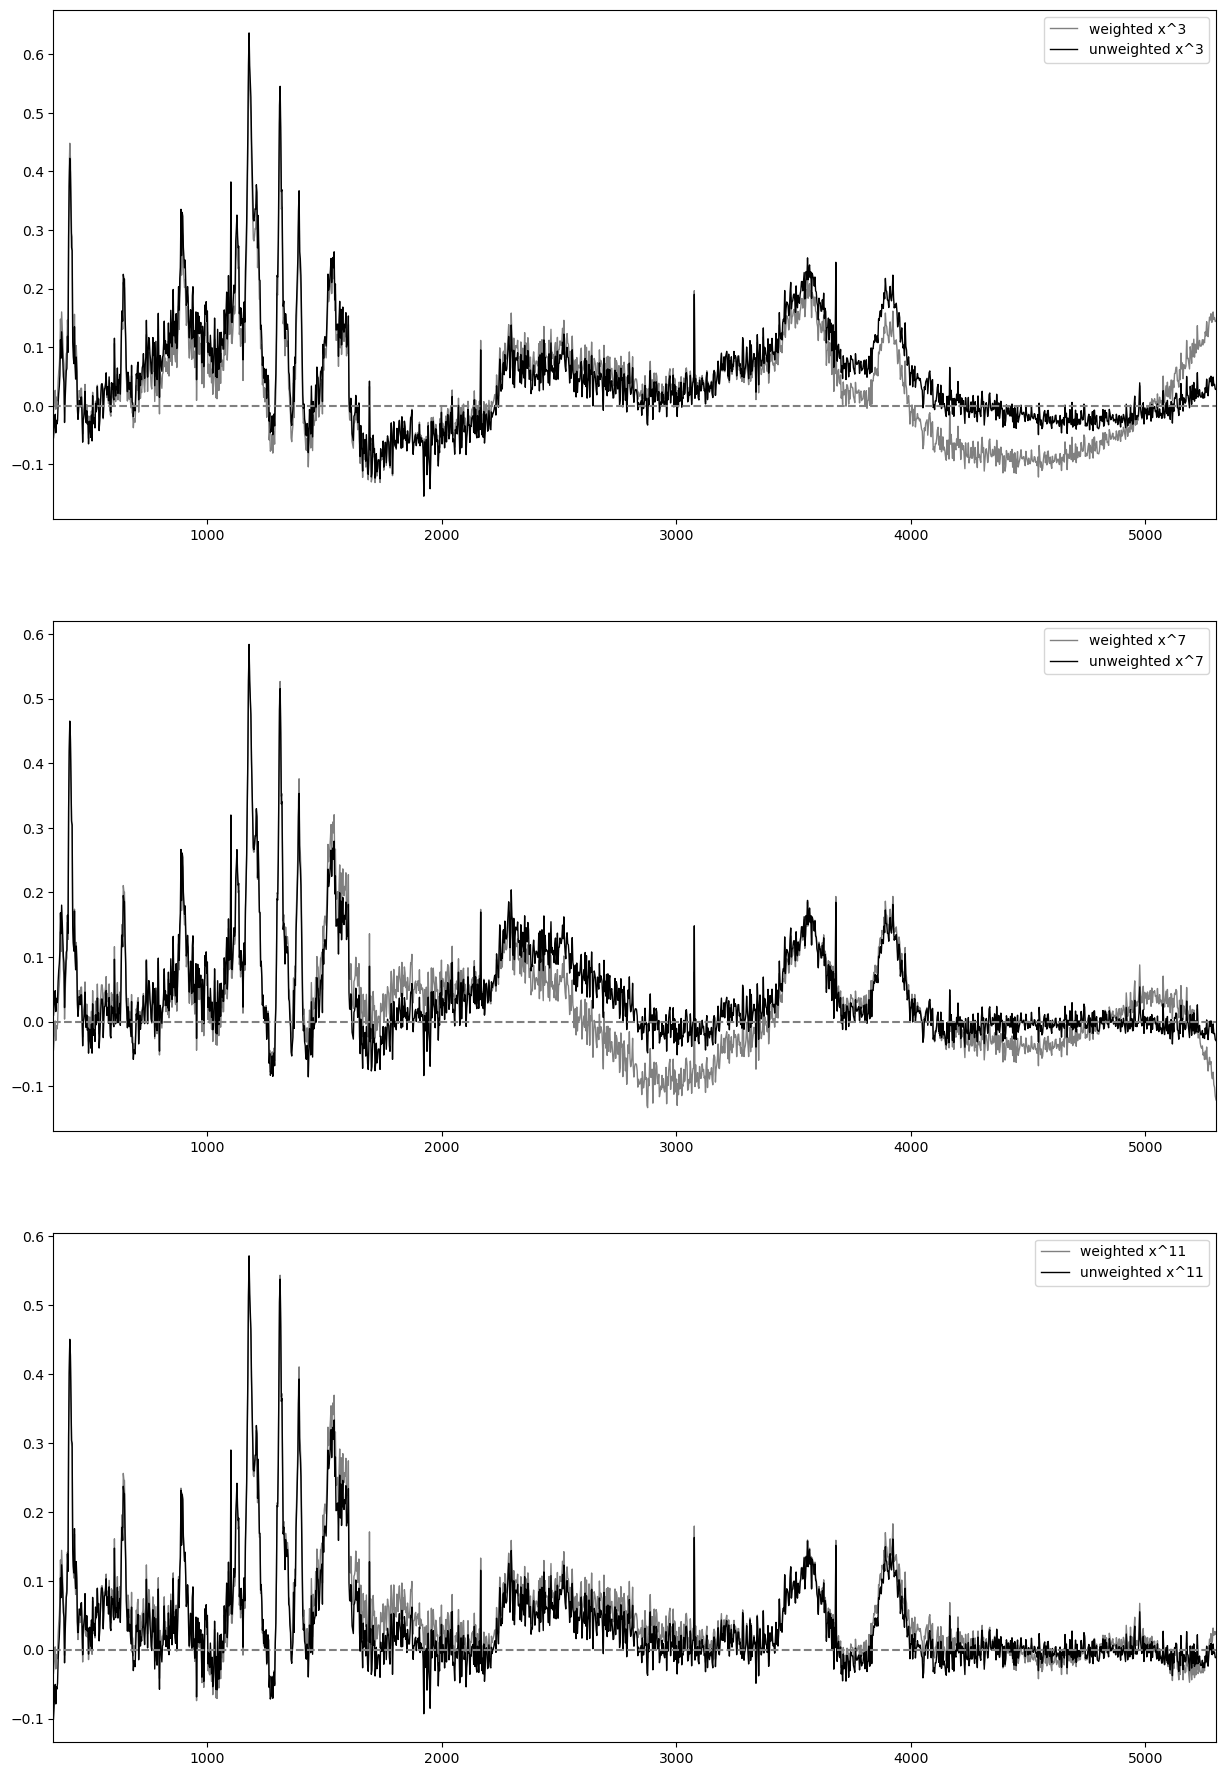

In [262]:
fig, ax = plt.subplots(3, figsize=(15, 22.5))

for i in range(3):
    ax[i].plot(f0_wvn, gnorm(f0_s) - f0_fit_w[i](f0_wvn), c='gray',  lw=1, label=wl[i])
    ax[i].plot(f0_wvn, gnorm(f0_s) - f0_fit_u[i](f0_wvn), c='black', lw=1, label=ul[i])
    ax[i].axhline(c='gray', ls='--')
    ax[i].legend()
    ax[i].set_xlim(min(f0_wvn), max(f0_wvn))